In [272]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import tensorflow as tf
import altair as alt
import collections



from src.load_data import read_tables
from src.item_recommender import ItemRecommender
from src.CFModel import CFModel, build_CF_model, compute_scores, book_neighbors, user_recommendations
from src.Baseline_Model import build_baseline_model

### load data

In [145]:
books, reviews = read_tables('data')

counting file: data/goodreads_reviews_mystery_thriller_crime.json.gz
current line: 0,1000000,complete
done!
counting file: data/goodreads_books_mystery_thriller_crime.json.gz
current line: 0,complete
done!


In [147]:
books.head(1)

,book_id,title,num_pages,is_ebook,link,average_rating,ratings_count,text_reviews_count,author_id,publisher,similar_books,old_book_id
1,75512,The House of Memory (Pluto's Snitch #2),318,1,https://www.goodreads.com/book/show/33394837-the-house-of-memory,4.33,269,60,242185,,[],33394837


In [148]:
reviews.head(1)

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id
620327,d23dc89ab32cd864e54d18369751163b,102489,37120,3,2001-01-01 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,196084


## Models

initially we wanted to use evaluation score: the mean of each user's top 5 recommended books' actual rating

since 85% of the users in test data only have 1 ratings, the evaluation score is almost the same (3.865) no matter recommendations are based on which model. (will delete the score later)

we will use mse as evaluation score considering our dataset is sparse

### baseline model - global mean

baseline estimate for r_xi = u + b_x + b_i

u: global mean (overall mean book ratings)

b_x: rating deviation of user x = (avg. rating of user x) - u

b_i: rating deviation of book i = (avg. rating of book i) - u

In [174]:
train_mse, test_mse, eval_score = build_baseline_model(reviews)

train mse: 15.53125 n/ test_mse: 15.97210 n/ evaluation_score: 3.86546


### CF model with adam optimizer

In [178]:
from src.CFModel import build_rating_sparse_tensor, sparse_mean_square_error, compute_score, split_dataframe

In [198]:
# matrix factorization without regularization with adam optimizer
# adam optimizer -> adaptive moment estimation with changing learning rate 
# https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

model_adam = build_CF_model(reviews, embedding_dim=30, init_stddev=0.05)

 iteration 600: train_error=0.011513, regularization_error=0.000000, gravity_loss=0.000000, test_error=16.561686

[{'train_error': 0.0115134055,
  'regularization_error': 0.0,
  'gravity_loss': 0.0,
  'test_error': 16.561686}]

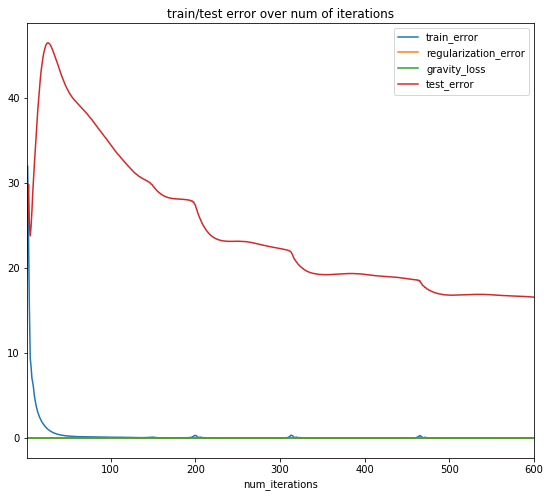

In [199]:
model_adam.train(num_iterations=600)

### CF model with regularization and adam optimizer

In [253]:
# A CFModel object that uses a regularized loss with adam optimizer
model_reg, test_ratings = build_CF_model(reviews, embedding_dim=30, init_stddev=0.05, 
                    regularization_coeff=0.1,
                    gravity_coeff=0.0)

 iteration 50: train_error=0.138442, regularization_error=0.749885, gravity_loss=0.000000, test_error=6.2360638

[{'train_error': 0.1384417,
  'regularization_error': 0.7498854,
  'gravity_loss': 0.0,
  'test_error': 6.2360635}]

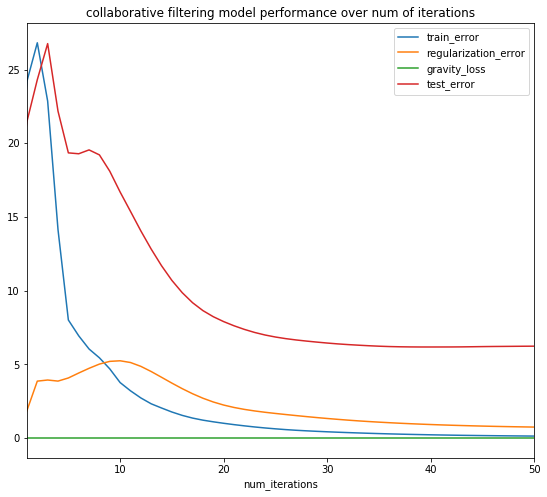

In [254]:
model_reg.train(num_iterations=50)

In [250]:
# A CFModel object that uses a regularized loss, gravity loss with adam optimizer
model_reg_grv, test_ratings = build_CF_model(reviews, embedding_dim=30, init_stddev=0.05, 
                    regularization_coeff=0.1,
                    gravity_coeff=0.1)

 iteration 50: train_error=0.143481, regularization_error=0.742101, gravity_loss=0.099898, test_error=7.7050402

[{'train_error': 0.1434815,
  'regularization_error': 0.74210066,
  'gravity_loss': 0.09989754,
  'test_error': 7.7050405}]

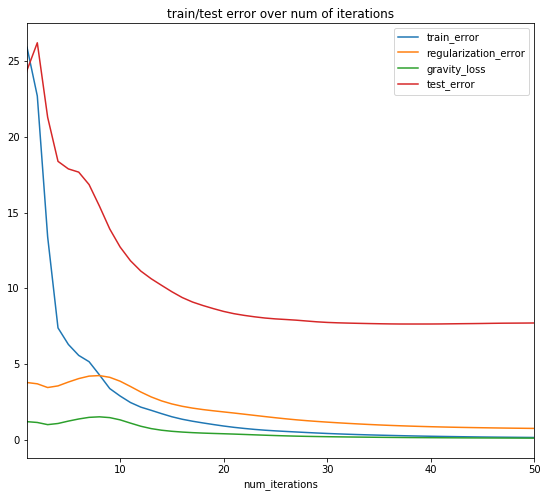

In [252]:
model_reg_grv.train(num_iterations=50)

#### evaluation score is calculated based on  the mean of the top 5% recommended books' actual ratings

since 85% of the users in test data only have 1 ratings, the evaluation score is almost the same (3.865) no matter recommendations are based on which model. (will delete the score later)

In [234]:
eval_score(test_ratings, model_reg.embeddings['user_id'], model_reg.embeddings['book_id'] )

/Users/elainewu/Documents/Projects/Assignments/Capstone/Capstone Three/GoodRead Recommender/src/CFModel.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "book_id": V


3.8654559983502605

In [248]:
# 85% of the users in test data only have 1 ratings
(test_ratings.user_id.value_counts() >1).sum()/len(test_ratings)

0.14314713615507552

In [255]:
# save model_embeddings
np.savez('model/model_reg_embeddings.npz', model_reg.embeddings['user_id'], model_reg.embeddings['book_id'])

In [110]:
# load model_embeddings

# file = np.load('model/model_reg_embeddings.npz')
# user_embeddings = file['arr_0']
# book_embeddings = file['arr_1']

### Explore model_reg performance

#### get recommendations for a given user

In [256]:
#example with user 'd889b42d9eb7b80e02f24830e27c6389'
user_id = 'fca26c34be8fe623ee340061f1281796'
sample_user_pred = user_recommendations(books, reviews, model_reg, user_id, measure='cosine', k=6)

The highest recommendations for user fca26c34be8fe623ee340061f1281796.


In [259]:
sample_user_pred.sort_values('cosine score', ascending=False)[:5]

,cosine score,titles,is_ebook,average_rating,ratings_count,text_reviews_count
69225,0.9309219717979431,Seizure,0,4.16,7,4
49762,0.9274286031723022,Dear Mr. M,1,3.29,220,19
198366,0.9250509738922119,"Carrots (Shelby Nichols, #1)",0,3.75,16,7
171115,0.9231846928596497,Dead Is Better,0,4.12,18,7
170228,0.9153721332550049,Picture Her Dead (Rhona MacLeod #8),0,4.04,85,17


In [85]:
sample_user_pred = sample_user_pred.reset_index()

In [87]:
sample_user_pred.head()
sample_user_pred.columns = ['old_book_id', 'cosine score', 'titles', 'is_ebook', 'average_rating', 'ratings_count', 'text_reviews_count']

In [82]:
sample_user_actual = reviews[reviews.old_user_id == 'fca26c34be8fe623ee340061f1281796']

In [91]:
sample_user_actual.head()

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id
3765,fb89469b4f0bc239db8003b0989d0f9b,119717,23582,1,2007-08-06 06:06:11,0,0,fca26c34be8fe623ee340061f1281796,1653254
3844,714613442f497a577f9f5af133864142,119717,17437,4,2007-08-07 16:56:36,3,0,fca26c34be8fe623ee340061f1281796,149576
3846,0d9147c5c9f7fe6efd127743bd5b90fe,119717,12590,2,2007-08-07 16:58:55,1,0,fca26c34be8fe623ee340061f1281796,1328722
3847,bd0f80100980a41524fafc29cb41be20,119717,10680,5,2007-08-07 17:02:17,1,0,fca26c34be8fe623ee340061f1281796,1293660
3848,85eb8a30584cafb745d4df25b26a9ecf,119717,99148,3,2007-08-07 17:03:14,1,0,fca26c34be8fe623ee340061f1281796,84785


In [92]:
for_sample_user_model = sample_user_pred.merge(sample_user_actual, how='left', left_on='old_book_id', right_on = 'old_book_id')

In [93]:
for_sample_user_model.head()

,old_book_id,cosine score,titles,is_ebook,average_rating,ratings_count,text_reviews_count,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id
0,10000063,0.14918702840805054,The Two Deaths of Daniel Hayes,0,3.49,1698,297,NaN,nan,nan,nan,NaN,nan,nan,NaN
1,10000067,0.2064065933227539,Pressure,1,4.0,16,4,NaN,nan,nan,nan,NaN,nan,nan,NaN
2,10000114,0.023210614919662476,The Devil's Graveyard,0,3.94,38,7,NaN,nan,nan,nan,NaN,nan,nan,NaN
3,10000131,0.13956785202026367,The Taking,0,3.78,4,2,NaN,nan,nan,nan,NaN,nan,nan,NaN
4,10000267,0.4012167453765869,"Die For Me (Romantic Suspense, #7; Daniel Vartanian, #1)",1,4.25,12,5,NaN,nan,nan,nan,NaN,nan,nan,NaN


In [62]:
user_df = reviews.groupby('old_user_id').count()['rating']
user_df.head()


old_user_id
00009e46d18f223a82b22da38586b605    15
0000c3d51aa099745e93a4e99c4856c8    4 
000192962b87d560f00b06fdcbd71681    2 
000253cf1077f203bca050637f2ec7f7    6 
00048fe3297cbb92a6e9fb78a6dce421    2 
Name: rating, dtype: int64

In [69]:
(user_df.sort_values(ascending=False) > 30).sum()/len(user_df)

0.08478319995384603

In [70]:
user_df.sort_values(ascending=False) > 30

old_user_id
fca26c34be8fe623ee340061f1281796    True 
795595616d3dbd81bd16b617c9a1fa48    True 
da1e69dbd8e0016bc5d39a9de2c3c753    True 
a45fb5d39a6a9857ff8362900790510a    True 
ba7f50286295186a87feaeb42af2ebc1    True 
                                    ...  
35e294edf62166c1e8ccfcef45c5f392    False
215ef5505ff9ac2b7b2abdfe913e6d76    False
215d9642849e73d67676431aa28516a0    False
0d41532480bd79738e5ab52a705087ef    False
21f61a8d0e5c0fabf6bf0dc1733311c0    False
Name: rating, Length: 121333, dtype: bool

### get neighbors of a book which contains a given substring

In [276]:
title_substring ='Crowner'
book_neighbors(books, reviews, model_reg, title_substring, measure='cosine', k=10)

Nearest neighbors of : Crowner's Crusade (Crowner John Mystery #15).
[Found more than one matching book. Other candidates: Crowner's Quest (Crowner John Mystery #3), The Poisoned Chalice (Crowner John Mystery #2), The Grim Reaper (Crowner John Mystery #6), The Elixir of Death (Crowner John Mystery #10), Figure of Hate (Crowner John Mystery #9), The Manor of Death (Crowner John Mystery #12), A Plague of Heretics (Crowner John Mystery #14), The Witch Hunter (Crowner John Mystery #8), The Sanctuary Seeker (Crowner John Mystery #1), Fear in the Forest (Crowner John Mystery #7), The Noble Outlaw (Crowner John Mystery #11)]


,cosine score,titles,is_ebook,average_rating,ratings_count
40489,0.9999999403953552,"Obsession (Faces of Evil, #1)",1,4.07,529
99193,0.8655579090118408,"Comeback (Parker, #17)",0,4.1,79
23598,0.8367605209350586,"The Lithium Murder (Periodic Table, #3)",0,3.64,94
132161,0.8343894481658936,"Death and Restoration (Jonathan Argyll, #6)",0,3.67,750
188204,0.8308665156364441,"A Ghostly Light (Haunted Home Renovation Mystery, #7)",0,4.27,457
45208,0.8211731314659119,Scourge,1,3.93,467
83480,0.821016788482666,Privileged Information,0,3.93,23
7311,0.8208984136581421,One Fateful Summer,0,4.25,24
136998,0.8203662037849426,Syndrome E,0,3.83,17
134725,0.8201779127120972,The Last Bridge: A Novel,0,3.71,73


### inspect neighbor clustering

In [101]:
def book_embedding_norm(books, models):
    """
    visualizes the norm and number of ratings of the book
    Args:
        model: a MFmodel object
    """
    if not isinstance(models, list):
        models = [models]
    df=pd.DataFrame({
        'title': books['title'],
        'average_rating': books['average_rating'],
        'ratings_count':books['ratings_count']
    })
    charts = []
    brush = alt.selection_interval()
    for i, model in enumerate(models):
        norm_key = 'norm' +str(i)
        df[norm_key] = np.linalg.norm(model.embeddings['book_id'], axis=1) #only included the first 1000 books for visualization
        nearest = alt.selection(
                type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
                empty='none')
        base = alt.Chart().mark_circle().encode(
                x='ratings_count',
                y=norm_key,
               color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
            ).properties(selection=nearest).add_selection(brush)
        text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='ratings_count', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
        charts.append(alt.layer(base, text))
    return alt.hconcat(*charts, data=df[:1000])
    
    

In [127]:
def visualize_movie_embeddings(data, x, y):
    nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
    base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(is_ebook_filter, "is_ebook", alt.value("whitesmoke")),
      ).properties(
      width=600,
      height=600,
      selection=nearest)
    text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
    return alt.hconcat(alt.layer(base, text), is_ebook_chart, data=data[:5000])


In [126]:
is_ebook_filter = alt.selection_multi(fields=['is_ebook'])
is_ebook_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('is_ebook'),
    color=alt.condition(
        is_ebook_filter,
        alt.Color("is_ebook:N"),
        alt.value('lightgray'))
).properties(height=300, selection=is_ebook_filter)

In [128]:
def tsne_movie_embeddings(model, books):
    """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
    Args:
    model: A MFModel object.
    """
    tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

    print('Running t-SNE...')
    V_proj = tsne.fit_transform(model.embeddings["book_id"][:5000])
    books.loc[:,'x'] = V_proj[:, 0]
    books.loc[:,'y'] = V_proj[:, 1]
    return visualize_movie_embeddings(books, 'x', 'y')

In [100]:
model.embeddings['book_id'].shape, len(books)

((105365, 30), 105365)

In [102]:
book_embedding_norm(model)

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


### softmax model

In [39]:
rated_books =(reviews[['user_id', 'book_id']].groupby('user_id', as_index=False).aggregate(lambda x: list(x)))
rated_books.head()

,user_id,book_id
0,0,"[82014, 83650, 20417, 84776, 65947, 3912, 1016, 23365, 2724, 12991, 21534, 44449, 41186, 95668, 93301]"
1,1,"[17124, 43808, 52912, 55484]"
2,2,"[23301, 87786]"
3,3,"[41186, 16813, 31831, 22647, 30562, 82014]"
4,4,"[41982, 76229]"


In [53]:
for book, average_rating in zip(books['book_id'].values(), books['average_rating'].values()):
    print(book, average_rating)
    break
# book id is index in books df

In [54]:
average_rating_dict ={book: average_rating for book, average_rating in zip(books['book_id'].values, books['average_rating'])}
ratings_count_dict ={book: ratings_count for book, ratings_count in zip(books['book_id'], books['ratings_count'])}
text_reviews_count_dict ={book: text_reviews_count for book, text_reviews_count in zip(books['book_id'], books['text_reviews_count'])}
is_ebook_dict = {book: is_ebook for book, is_ebook in zip(books['book_id'], books['is_ebook'])}

In [ ]:
def make_batch(reviews, batch_size):
    """build a tensor input pipeline
    creates a batch of examples
    Args:
    ratings: A DataFrame of ratings such that examples["book_id"] is a list of
    movies rated by a user.
    batch_size: The batch size.
    """
    def pad(x, fill):
        return pd.DataFrame.from_dict(x).fillna(fill).values
    
    book = []
    average_rating = []
    ratings_count = []
    text_reviews_count = []
    label = []
    for book_ids in reviews["book_id"].values:
        book_ids_1 = reviews[reviews['book_id'] == book_ids].old_book_ids.values[0]
        book.append(book_ids)
        average_rating.append([x for book_id in book_ids for x in average_rating_dict[book_id]])
        ratings_count.append([ratings_count_dict[book_id] for book_id in book_ids])
        text_reviews_count.append([text_reviews_count_dict[book_id] for book_id in book_ids])
        label.append([int(book_id) for book_id in book_ids])
    features = {
      "book_id": pad(book, ""),
      "average_rating": pad(average_rating, ""),
      "ratings_count": pad(ratings_count, ""),
      "text_reviews_count": pad(text_reviews_count, ""),
        "label": pad(label, -1)
        }
    batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
    return batch
    